In [2]:
import mesa
import mesa.agent

# Copy of the model

In [3]:
import mesa
import numpy as np
import mesa
import random
import matplotlib.pyplot as plt
import modules

NO_NEIGHBORS_THETA = 0.5

class SchellingAgent(mesa.Agent):
    """
    Schelling segregation agent
    """

    def __init__(self, unique_id, model, agent_type, budget):
        """
        Create a new Schelling agent.

        Args:
           unique_id: Unique identifier for the agent.
           agent_type: Indicator for the agent's type (minority=1, majority=0)
           budget: Budget for the agent
        """
        super().__init__(unique_id, model)
        self.type = agent_type
        self.budget = budget
        self.utility = 0.5
        self.segregation = None
        self.move_counter = 0

    def calc_theta(self):
        # Calculate theta using the model's get_theta method
        self.segregation = modules.get_theta(self.model, self.pos, self.type)

    def step(self):
        """
        Step for agent to move
        In a step an agent will:
            1. Find available properties to move to
            2. Calculate their utility for each property
            3. If the property with the highest utility has a higher utility than the current property, move there
            4. Update the utility of the agent in their new location
        """
        # update utility
        self.utility = self.model.utility_func(self.model, self, self.pos)
        
        self.calc_theta()

        # find the available properties to move to
        available_cells = self.model.find_available_cells(self)
                
        if len(available_cells) < 0:
            return
        
        # list all utilities of available properties
        move_util = []
        for cell in available_cells:
            # store as (cell, utility) tuple
            move_util.append((cell, self.model.utility_func(self.model, self, cell)))
        
        # sort by utility
        move_util.sort(key=lambda x: x[1], reverse=True)
        
        # move if utility is higher than current
        if move_util[0][1] > self.utility:
            self.model.grid.move_agent(self, move_util[0][0])
            # update utility
            self.utility = move_util[0][1]
            self.move_counter += 1


class Schelling(mesa.Model):
    """
    Model class for the Schelling segregation model.
    """

    def __init__(
        self,
        property_value_func,
        income_func,
        desirability_func,
        utility_func,
        price_func,
        height=20,
        width=20,
        homophily=0.5,
        radius=1,
        density=0.8,
        minority_pc=0.2,
        alpha=0.5,
        income_scale=1.5, # the scale by which the income is higher than the property value
        property_value_weight=0.1,
        mu_theta = 0.5,
        sigma_theta = 0.1,
        seed=None
    ):
        """
        Create a new Schelling model.

        Args:
            width, height: Size of the space.
            density: Initial chance for a cell to be populated
            minority_pc: Chance for an agent to be in minority class
            homophily: Minimum number of agents of the same class needed to be happy
            radius: Search radius for checking similarity
            seed: Seed for reproducibility
            property_value: Value for the property
        """

        super().__init__(seed=seed)
        self.utility_func = utility_func
        self.price_func = price_func
        self.desirability_func = desirability_func
        self.prop_value_weight = property_value_weight
        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily
        self.radius = radius
        self.alpha = alpha
        self.mu_theta = mu_theta
        self.sigma_theta = sigma_theta
        
        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.SingleGrid(width, height, torus=True)

        # Property Value Layer
        self.property_value_layer = property_value_func(name="property_values", width=width, height=height)
        self.grid.add_property_layer(self.property_value_layer)

        # Desirability Layer
        self.desirability_layer = mesa.space.PropertyLayer("desirability", width, height, 0.5)
        # for _, pos in self.grid.coord_iter():
        #     self.desirability_layer[pos] = 1
        self.grid.add_property_layer(self.desirability_layer)
        
        # Interested Agents Counter Layer
        self.interested_agents_layer = mesa.space.PropertyLayer("interested_agents", width, height, 0)
        # for _, pos in self.grid.coord_iter():
        #     self.interested_agents_layer[pos] = 0
        self.grid.add_property_layer(self.interested_agents_layer)
        
        # Utility Layer
        self.utility_layer = mesa.space.PropertyLayer("utility", width, height, 0.5) 
        self.grid.add_property_layer(self.utility_layer)

        #Data Collectors
        self.datacollector = mesa.DataCollector(
            agent_reporters={"Utility": "utility", "Segregation":"segregation", "Moves":"move_counter"}, model_reporters={"Desirability": self.desirability_layer.data.tolist}  # Collect the utility of each agent
        )

        # Set up agents
        for _, pos in self.grid.coord_iter():
            if self.random.random() < self.density:
                agent_type = 1 if self.random.random() < self.minority_pc else 0
                budget = income_func(scale=income_scale)
                agent = SchellingAgent(self.next_id(), self, agent_type, budget)
                self.grid.place_agent(agent, pos)
                self.schedule.add(agent)

        self.datacollector.collect(self)

    def find_available_cells(self, agent):
        available_cells = []
        for _, pos in self.grid.coord_iter():
            if self.grid.is_cell_empty(pos):
                available_cells.append(pos)        
        return available_cells

    def step(self):
        """
        Run one step of the model.
        """
        # Set the count of agents who like to move somewhere to 0 for all cells
        self.interested_agents_layer.set_cells(0)

        for agent in self.schedule.agents:
            # Iterate over cells and compare utility to current location, add to interested_agents_layer if better
            for _, loc  in self.grid.coord_iter():
                utility = self.utility_func(self, agent, loc)
                
                if utility > agent.utility:
                    self.interested_agents_layer.modify_cell(loc, lambda v: v + 1)

        # Set desirability layer to the proportion of interested agents
        num_agents = len(self.schedule.agents)
        self.desirability_layer.set_cells(
            self.desirability_func(self, prop_value_weight=self.prop_value_weight)
        )
        
        self.schedule.step()
        self.datacollector.collect(self)

# import modules
# # Create and run the model
# model = Schelling(
#     property_value_func=modules.property_value_quadrants,
#     utility_func=modules.utility_func,
#     price_func=modules.price_func,
#     height=20,
#     width=20,
#     homophily=0.5,
#     radius=1,
#     density=0.8,
#     minority_pc=0.2,
#     alpha=0.5,
#     seed=42
# )

# # Run the model for a certain number of steps
# for i in range(5):
#     print(i)
#     model.step()

# # Retrieve the collected data
# agent_data = model.datacollector.get_agent_vars_dataframe()
# model_data = model.datacollector.get_model_vars_dataframe()

# print(agent_data)

In [4]:
import mesa
import mesa.agent
import numpy as np


NO_NEIGHBORS_THETA = 0.5

def property_value_func_random(name, width, height) -> mesa.space.PropertyLayer:
    layer = mesa.space.PropertyLayer(name, width, height, 0)
    
    # parameters
    beta = 400
    mu = 1200
    
    for i in range(height):
        for j in range(width):
            rent = np.random.gumbel(loc=mu, scale=beta)
            layer.set_cell((i, j), abs(rent))

    return layer

def property_value_quadrants(name, width, height) -> mesa.space.PropertyLayer:
    layer = mesa.space.PropertyLayer(name, width, height, 0)
    
    for i in range(height):
        for j in range(width):
            if i < height/2:
                if j < width/2:
                    rent = 500
                else:
                    rent = 1000
            else:
                if j < width/2:
                    rent = 1000
                else:
                    rent = 2000
            layer.set_cell((i, j), abs(rent))

    return layer

def income_func(scale=1.5):
    # Use the same gumbel distribution as the property value, but scale with scale value
    return np.random.gumbel(loc=400, scale=1200) * scale

# def utility_func(model: mesa.Model, agent: mesa.Agent, property_loc: tuple) -> float:
#     # agent_loc = agent.pos
    
#     theta = model.get_theta(property_loc, agent.type)

#     desirability = model.desirability_layer.data[property_loc]

#     alpha = model.alpha

#     budget = agent.budget
    
#     price = model.price_func(model, property_loc)
    
#     return theta**alpha*desirability**(1-alpha)*((budget-price)/budget)

def desirability_func(model: mesa.Model, prop_value_weight: float = 0.1) -> float:
    
    
    most_expensive_prop = np.max(model.property_value_layer.data)
    num_agents = len(model.schedule.agents)
    
    return prop_value_weight * model.property_value_layer.data / most_expensive_prop + (1-prop_value_weight) * model.interested_agents_layer.data / num_agents

def utility_func(model: mesa.Model, agent: mesa.Agent, property_loc: tuple) -> float:
    # agent_loc = agent.pos
    
    theta = get_theta(model, property_loc, agent.type)

    desirability = model.desirability_layer.data[property_loc]

    alpha = model.alpha

    budget = agent.budget
    
    price = model.price_func(model, property_loc)
    
    if budget < price:
        return 0
    
    return theta**alpha*desirability**(1-alpha)


def price_func(model: mesa.Model, property_loc: tuple) -> float:
    
    desirability = model.desirability_layer.data[property_loc]
    property_value = model.property_value_layer.data[property_loc]
    
    return (0.5 + desirability) * property_value

def get_theta(model: mesa.Model, loc: tuple, type):
    similar = 0
    num_neighbours = 0
    
    for neighbor in model.grid.iter_neighbors(
        loc, moore=True, radius=model.radius
    ):
        
        num_neighbours += 1
        if neighbor.type == type:
            similar += 1
    
    if num_neighbours == 0:
        return NO_NEIGHBORS_THETA
            
    proportion_similar = similar / num_neighbours

    theta = np.exp(-((proportion_similar - model.mu_theta) ** 2) / (2 * model.sigma_theta ** 2))

    return theta #proportion_similar
    
    #return proportion_similar


def compute_entropy(model: mesa.Model, loc: tuple, type):
    similar = 0
    num_neighbours = 0

    for neighbor in model.grid.iter_neighbors(
        loc, moore=True, radius=model.radius
    ):
        
        num_neighbours += 1
        if neighbor.type == type:
            similar += 1
    
    if num_neighbours == 0:
        return NO_NEIGHBORS_THETA
    return similar

# Added modules

In [ ]:
def get_theta(x, mu, sigma):
    """
    x: fraction of similar neighbours
    mu: optimal fraction of similar neighbours
    sigma: acceptance range
    """
    theta = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return theta

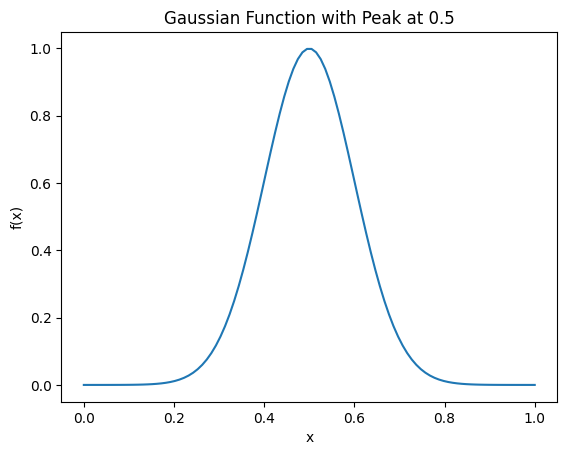

In [33]:
def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Example usage:
x_values = np.linspace(0, 1, 100)
mu = 0.5  # Peak in the middle
sigma = 0.1  # Controls the width

y_values = gaussian_function(x_values, mu, sigma)

# You can plot the function to visualize it
import matplotlib.pyplot as plt

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Gaussian Function with Peak at {mu}')
plt.show()